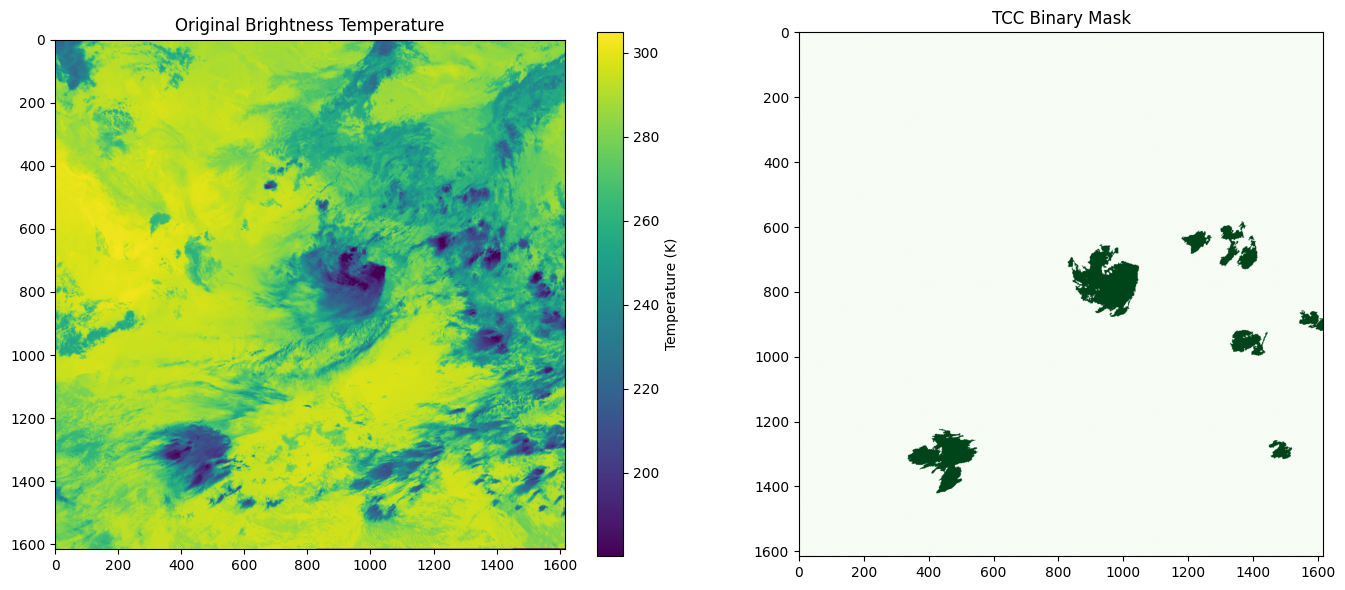

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

def load_tiff(filepath):
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(np.float32)
    return data

def create_tcc_mask(data, threshold=220, km_per_pixel=4.0, min_radius_km=111, min_area_km2=34800):
    # Step 1: Temperature threshold
    tb_mask = data < threshold
    
    # Step 2: Radius filtering
    min_area_pixels_radius = np.pi * (min_radius_km / km_per_pixel)**2
    labeled_radius = label(tb_mask)
    radius_filtered_mask = np.zeros_like(tb_mask, dtype=bool)
    
    for region in regionprops(labeled_radius):
        if region.area >= min_area_pixels_radius:
            radius_filtered_mask[labeled_radius == region.label] = True
    
    # Step 3: Area filtering
    min_area_pixels_area = min_area_km2 / (km_per_pixel ** 2)
    labeled_area = label(radius_filtered_mask)
    final_mask = np.zeros_like(tb_mask, dtype=bool)
    
    for region in regionprops(labeled_area):
        if region.area >= min_area_pixels_area:
            final_mask[labeled_area == region.label] = True
    
    return final_mask

def plot_mask(original_data, binary_mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    im1 = ax1.imshow(original_data, cmap='viridis')
    ax1.set_title("Original Brightness Temperature")
    plt.colorbar(im1, ax=ax1, label="Temperature (K)")
    
    im2 = ax2.imshow(binary_mask, cmap='Greens')
    ax2.set_title("TCC Binary Mask")
    
    plt.tight_layout()
    plt.show()

# === USAGE ===
input_file = r"mosdac_data\3DIMG_02AUG2023_2130_L1C_ASIA_MER_V01R00_IMG_TIR1.tif"  # <-- Replace with your file
data = load_tiff(input_file)
binary_mask = create_tcc_mask(data)
plot_mask(data, binary_mask)


c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\schak\AppData\Local\Programs\Python\Python310\lib\subp

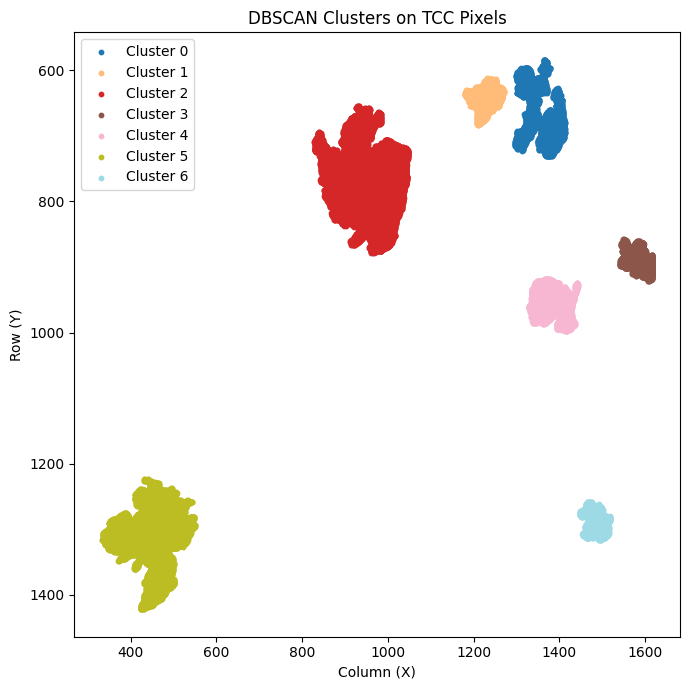

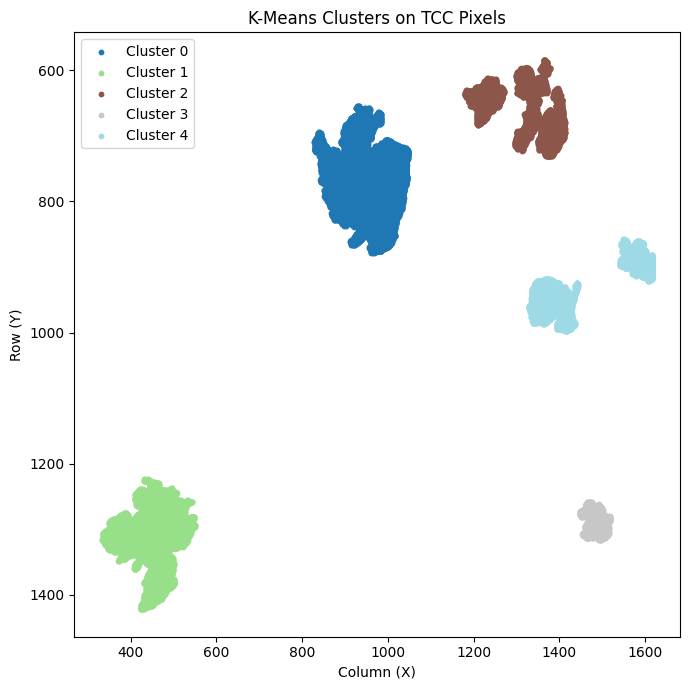

In [ ]:
from sklearn.cluster import DBSCAN, KMeans

def cluster_tcc_pixels(binary_mask, method='dbscan', eps=10, min_samples=20, k=5):
    # Extract (row, col) of TCC pixels
    coords = np.column_stack(np.where(binary_mask))
    
    if method == 'dbscan':
        model = DBSCAN(eps=eps, min_samples=min_samples)
    elif method == 'kmeans':
        model = KMeans(n_clusters=k, random_state=42)
    else:
        raise ValueError("Method must be 'dbscan' or 'kmeans'")
    
    labels = model.fit_predict(coords)
    return coords, labels

def plot_clusters(coords, labels, title):
    plt.figure(figsize=(7, 7))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab20', len(unique_labels))
    
    for lbl in unique_labels:
        if lbl == -1:
            # DBSCAN noise points
            color = 'k'
            size = 5
            label_name = 'Noise'
        else:
            color = colors(lbl)
            size = 10
            label_name = f'Cluster {lbl}'
        cluster_points = coords[labels == lbl]
        plt.scatter(cluster_points[:,1], cluster_points[:,0], s=size, color=color, label=label_name)
    
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Column (X)")
    plt.ylabel("Row (Y)")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# === Apply Clustering ===
coords_db, labels_db = cluster_tcc_pixels(binary_mask, method='dbscan', eps=15, min_samples=30)
coords_km, labels_km = cluster_tcc_pixels(binary_mask, method='kmeans', k=5)

# === Plot ===
plot_clusters(coords_db, labels_db, "DBSCAN Clusters on TCC Pixels")
plot_clusters(coords_km, labels_km, "K-Means Clusters on TCC Pixels")
